En primer lugar, importamos las bibliotecas necesarias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, make_scorer, fbeta_score

Configuramos una semilla aleatoria para reproducibilidad.

In [2]:
np.random.seed(123)

Cargamos el dataset que contiene indicadores de salud y diagnósticos de diabetes.

In [3]:
data = pd.read_csv('../data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

# Identificamos los tipos de columnas del dataset
binary_columns = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                  'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                  'NoDocbcCost', 'DiffWalk', 'Sex']
categorical_columns = ['GenHlth', 'Age', 'Education', 'Income']
continuous_columns = ['BMI', 'MentHlth', 'PhysHlth']

# Preprocesamos los datos transformando las columnas según aplique
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', 'passthrough', binary_columns),
        ('categorical', 'passthrough', categorical_columns),
        ('continuous', StandardScaler(), continuous_columns)
    ]
)

Dividimos los datos en conjuntos de entrenamiento y prueba, en proporción 80% -20%:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

Creamos un pipeline para KNN utilizando StandardScaler y el clasificador KNeighbors (de sklearn):

In [5]:
def create_rf_pipeline():

    return Pipeline([
        ('preprocessor', preprocessor),
        ('knn', KNeighborsClassifier())
    ])


Definimos la grilla, proporcionando diversas propuestas en los parámetros que pueden resultar útil. Se ha reducido el número de hiperparámetros de la grilla para no abarcar demasiado tiempo de ejecución, dado que tenemos un rango de k bastante amplio. De esta manera, se han descartado métricas de distancia como euclidean, manhattan y hamming, por reflejar un peor resultado, y nos hemos centrado en minkowski. 

Nota: En el notebook knn_minkowski_seleccion.ipynb la grilla es más amplia, abarcando valores desde 5 hasta 150, dando saltos de 6 en 6. Sin embargo, en este engrillado se ha optado por reducir el rango para comparar gráficamente la evolución del score, apreciando notablemente la diferencia de escala en comparación al rango [5, 150). Además, al haber comprobado en dicho notebook los hiperparámetros óptimos, podemos utilizar el segundo engrillado aplicado en este.

In [6]:
def get_grid_search_params():

    return { 
        'knn__n_neighbors': list(range(5, 42, 6)),          # Número de vecinos: entre 5 y 41
        'knn__metric': ['minkowski'],                       # Métricas a evaluar
        'knn__weights': ['uniform', 'distance'],            # Peso uniforme o basado en distancia
        'knn__p': [1, 1.5, 2, 3]                            # Parámetro de Minkowski (Manhattan: p=1, Euclídea: p=2)
    }

Configuramos GridSearch y aplicamos validación cruzada estratificada. Además, vamos a utilizar los scoring roc_auc, accuracy, recall y f2. Esta última métrica prioriza el recall, en comparación a f1-score, y será la utilizada para seleccionar el mejor modelo. Esto se debe a que, al ser un caso clínico, es preferible identificar correctamente la mayor cantidad posible de pacientes con diabetes, incluso si esto resulta en un pequeño incremento de los falsos positivos.

In [7]:
grid_search = GridSearchCV(
    estimator=create_rf_pipeline(),
    param_grid=get_grid_search_params(),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    scoring={
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'recall': 'recall',
        'f2': make_scorer(fbeta_score, beta=2)
    },
    refit='f2',
    n_jobs=-1,
    verbose=1
)

Recorremos toda la grilla, aplicando paralelización para acelerar el proceso:

In [8]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('binary',
                                                                         'passthrough',
                                                                         ['HighBP',
                                                                          'HighChol',
                                                                          'CholCheck',
                                                                          'Smoker',
                                                                          'Stroke',
                                                                          'HeartDiseaseorAttack',
                                                                          'PhysActivity',
                                                                          'Fruits',
                                                                          'Veggies',
                                                                          'HvyAlcoholConsump',
                                                                          'AnyHealthcare',
                                                                          'NoDocbcCost',
                                                                          'DiffWalk',
                                                                          'Sex']),
                                                                        (...
                                                                          'PhysHlth'])])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['minkowski'],
                         'knn__n_neighbors': [5, 11, 17, 23, 29, 35, 41],
                         'knn__p': [1, 1.5, 2, 3],
                         'knn__weights': ['uniform', 'distance']},
             refit='f2',
             scoring={'accuracy': 'accuracy',
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'recall': 'recall', 'roc_auc': 'roc_auc'},
             verbose=1)

Obtenemos los mejores parámetros de la búsqueda:

In [9]:
best_params = grid_search.best_params_
print(best_params)

{'knn__metric': 'minkowski', 'knn__n_neighbors': 41, 'knn__p': 2, 'knn__weights': 'uniform'}


Ahora vamos a visualizar como evoluciona el valor de Recall y AUC para cada k seleccionado:

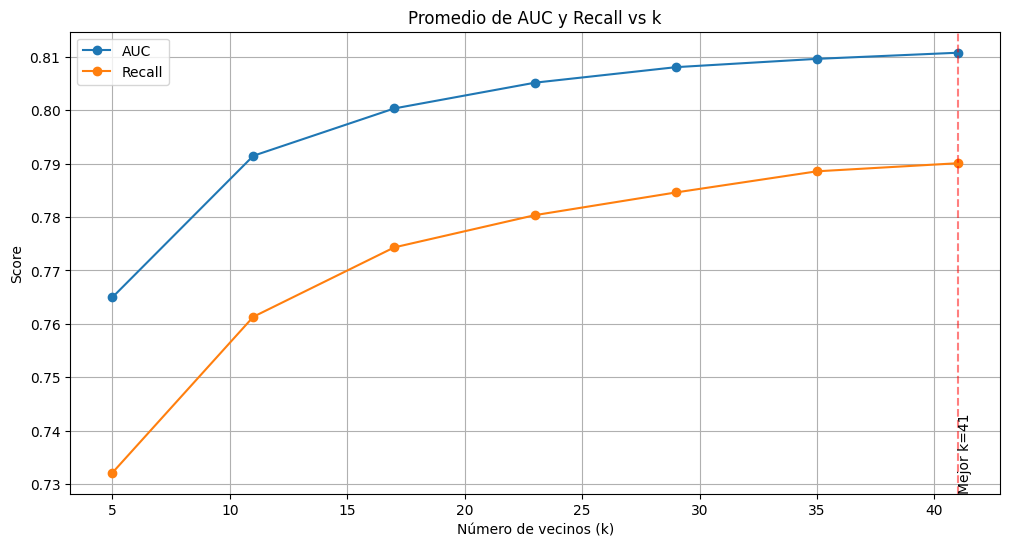

In [10]:
# Creamos un DataFrame para facilitar el análisis
results = grid_search.cv_results_

results_df = pd.DataFrame({
    'k': [params['knn__n_neighbors'] for params in results['params']],
    'metric': [params['knn__metric'] for params in results['params']],
    'weights': [params['knn__weights'] for params in results['params']],
    'p': [params['knn__p'] for params in results['params']],
    'auc': results['mean_test_roc_auc'],
    'recall': results['mean_test_recall']
})

# Agrupamos por k y calculamos el promedio de las métricas
k_summary = results_df.groupby('k')[['auc', 'recall']].mean()

# Visualizamos la evolución del score según el k seleccionado
plt.figure(figsize=(12, 6))
plt.plot(k_summary.index, k_summary['auc'], label='AUC', marker='o')
plt.plot(k_summary.index, k_summary['recall'], label='Recall', marker='o')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.title('Promedio de AUC y Recall vs k')

# Añadimos anotaciones para mejorar la interpretabilidad
plt.axvline(x=best_params['knn__n_neighbors'], color='r', linestyle='--', alpha=0.5)
plt.text(best_params['knn__n_neighbors'], plt.ylim()[0], f'Mejor k={best_params["knn__n_neighbors"]}', 
         rotation=90, verticalalignment='bottom')

plt.show()

Imprimimos las soluciones obtenidas

In [11]:
def find_optimal_threshold(fpr, tpr, thresholds, min_recall=0.85):
    for i, threshold in enumerate(thresholds):
        if tpr[i] >= min_recall:
            return threshold
    return thresholds[np.argmax(tpr - fpr)]


Best parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 41, 'knn__p': 2, 'knn__weights': 'uniform'}
Best cross-validation accuracy: 0.7760655676071521

Optimal Threshold: 0.44

Final Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.82      0.62      0.71      7070
         1.0       0.69      0.86      0.77      7069

    accuracy                           0.74     14139
   macro avg       0.76      0.74      0.74     14139
weighted avg       0.76      0.74      0.74     14139


Test set accuracy with Optimal Threshold: 0.7415


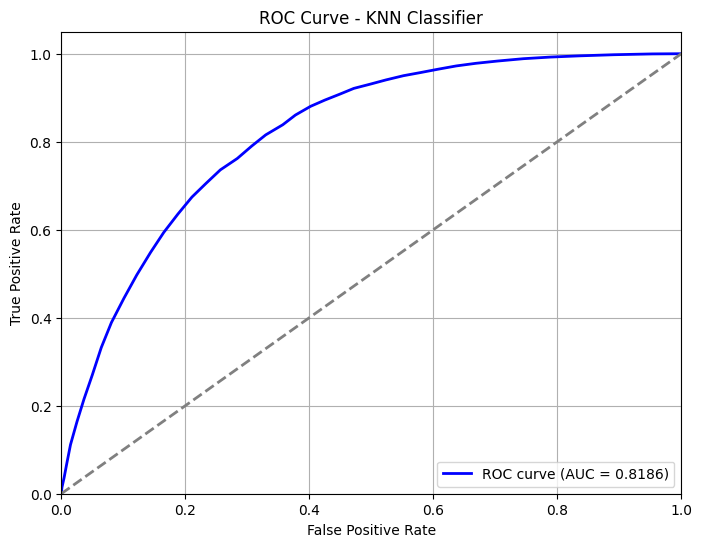


Confusion Matrix with Optimal Threshold:


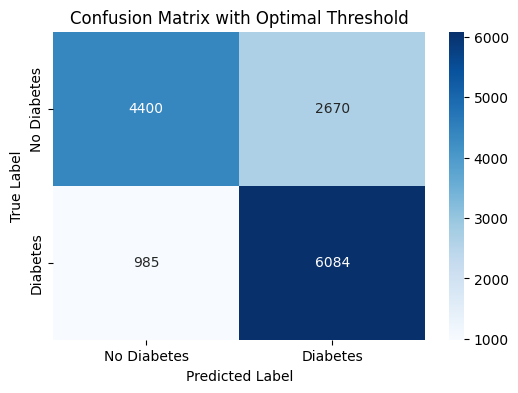

In [12]:
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Realizamos predicciones en el conjunto de prueba
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y obtenemos los verdaderos y falsos positivos (TPR y FPR) junto con los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Identificamos el umbral óptimo basándonos en la curva ROC
optimal_threshold = find_optimal_threshold(fpr, tpr, thresholds)
print(f"\nOptimal Threshold: {optimal_threshold:.2f}")

# Ajustamos las predicciones utilizando el umbral óptimo
y_pred_final = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluamos las métricas del modelo
print("\nFinal Classification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_final))

# Calculamos el accuracy del conjunto de prueba con el umbral óptimo
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"\nTest set accuracy with Optimal Threshold: {accuracy_final:.4f}")

# Representamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Finalmente, calculamos matriz de confusión
cm_final = confusion_matrix(y_test, y_pred_final)
print("\nConfusion Matrix with Optimal Threshold:")
plt.figure(figsize=(6, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix with Optimal Threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Una vez analizada la solución, podemos concluir:
- ROC AUC: 0.8056, lo que indica una mejor capacidad para distinguir entre las clases.
- Accuracy: 0.7295, reflejando un aumento en la proporción de predicciones correctas respecto a KNN

KNN logró un buen rendimiento general. Asimismo, gracias al uso de F2-Score como métrica predominante (dando más peso al recall que a la precisión), se ha priorizado la capacidad del modelo para detectar la mayor cantidad de casos positivos posibles (personas con diabetes), a cambio de un incremento en los falsos positivos. Esto se debe a que un falso negativo puede tener consecuencias serias en la práctica clínica, ya que el paciente no recibirá tratamiento ni seguimiento médico adecuado, derivando en complicaciones como problemas cardíacos, daño renal, ceguera o incluso la muerte. Por otro lado, un falso positivo genera una situación mucho menos grave: el paciente será sometido a pruebas adicionales para descartar la enfermedad, pero no compromete directamente la salud del paciente.